In [1]:
# coding: utf-8
import gym
import torch.utils.data as data
from dynamics import *
from controller import *
from utils import *
from quanser_robots.common import GentlyTerminating
import time

env_id = "CartpoleStabShort-v0"
env = GentlyTerminating(gym.make(env_id))
config_path = "config.yml"
config = load_config(config_path)
print_config(config_path)

************************
*** model configuration ***
load_model: false
model_path: storage/exp_1.ckpt
n_actions: 1
n_hidden: 1
n_states: 5
size_hidden: 512
use_cuda: true

*** train configuration ***
batch_size: 256
exp_number: 1
learning_rate: 0.001
n_epochs: 60
save_loss_fig: true
save_loss_fig_frequency: 10
save_model_flag: true
save_model_path: storage/exp_1.ckpt

************************
*** dataset configuration ***
load_flag: false
load_path: storage/data_exp_1.pkl
min_train_samples: 6000
mpc_dataset_split: 0.5
n_max_steps: 1000
n_mpc_episodes: 4
n_mpc_itrs: 100
n_random_episodes: 800
save_flag: true
save_path: storage/data_exp_1.pkl
testset_split: 0.2

************************
*** MPC controller configuration ***
action_high: 12
action_low: -12
gamma: 0.99
horizon: 12
max_itrs: 20
numb_bees: 8



In [2]:
'''Initialize the dynamic model'''
model = DynamicModel(config)

'''Initialize the dataset factory class'''
data_fac = DatasetFactory(env,config)

'''Collect dataset randomly'''
data_fac.collect_random_dataset()

Collect random dataset shape:  (86148, 6)


In [3]:
'''Train the dynamic model with the randomly collected dataset'''
loss = model.train(data_fac.random_trainset,data_fac.random_testset)

Total training step per epoch [270]
Epoch [10/60], Training Loss: 0.00054845, Test Loss: 0.00045981
Epoch [20/60], Training Loss: 0.00021198, Test Loss: 0.00017221
Epoch [30/60], Training Loss: 0.00015228, Test Loss: 0.00017445
Epoch [40/60], Training Loss: 0.00010878, Test Loss: 0.00011339
Epoch [50/60], Training Loss: 0.00007420, Test Loss: 0.00004770
Epoch [60/60], Training Loss: 0.00006049, Test Loss: 0.00006209


/home/xinye/projects/rl/RL-project/MPC/MPC-CartPoleStab/dynamics.py:61: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda()


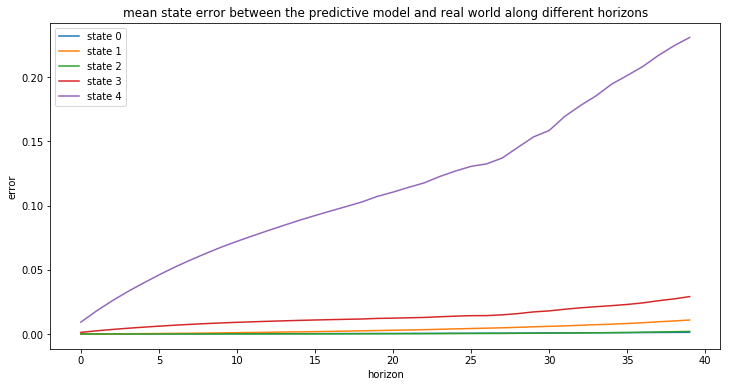

In [4]:
'''See the model errors along the horizon'''
model.plot_model_validation(env,n_sample=200,mode='mean')

In [5]:
'''Initialize the MPC controller'''
mpc = MPC(env,config)

In [6]:
'''Collect MPC based dataset, train the model, and iterate again and again'''
rewards_list = []
for itr in range(config["dataset_config"]["n_mpc_itrs"]):
    t = time.time()
    print("**********************************************")
    print("The reinforce process [%s], collecting data ..." % itr)
    
    '''Collect bootstrap dataset'''
    rewards = data_fac.collect_mpc_dataset(mpc,model)
    trainset, testset = data_fac.make_dataset()
    rewards_list += rewards
    
    plt.close("all")
    plt.figure(figsize=(12, 5))
    plt.title('Reward Trend with %s iteration' % itr)
    plt.plot(rewards_list)
    plt.savefig("storage/reward-" + str(model.exp_number) + ".png")
    print("Consume %s s in this iteration" % (time.time()-t))
    
    '''Retrain the model'''
    loss = model.train(trainset,testset)

**********************************************
The reinforce process [0], collecting data ...


/home/xinye/projects/rl/RL-project/MPC/MPC-CartPoleStab/dynamics.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda()


Episode [0/4], Reward: 1999.99681610
Episode [1/4], Reward: 1999.98267496
Episode [2/4], Reward: 1999.98380119
Episode [3/4], Reward: 1999.97932905
Totally collect 4000 data based on MPC
Saving all datas to storage/data_exp_1.pkl
Sample 4000 training data from all previous dataset, total training sample: 8000
Consume 8015.910554885864 s in this iteration
Total training step per epoch [32]
Epoch [10/60], Training Loss: 0.00020774, Test Loss: 0.00027712
Epoch [20/60], Training Loss: 0.00014069, Test Loss: 0.00030390
Epoch [30/60], Training Loss: 0.00013645, Test Loss: 0.00016956
Epoch [40/60], Training Loss: 0.00016601, Test Loss: 0.00022114
Epoch [50/60], Training Loss: 0.00011887, Test Loss: 0.00022269
Epoch [60/60], Training Loss: 0.00016810, Test Loss: 0.00018721
**********************************************
The reinforce process [1], collecting data ...
Episode [0/4], Reward: 1999.97866851
Episode [1/4], Reward: 1999.97135168
Episode [2/4], Reward: 1999.98450899
Episode [3/4], Rewa

KeyboardInterrupt: 